# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# Loading Data

## Loading themes.csv

In [2]:
themes_raw = pd.read_csv("themes.csv")
print(themes_raw.shape)
themes_raw.head()

(671, 3)


,id,name,parent_id
0,1,Technic,NaN
1,2,Arctic Technic,1.0
2,3,Competition,1.0
3,4,Expert Builder,1.0
4,5,Model,1.0


In [3]:
themes_raw.describe()

,id,parent_id
count,671.000000,550.000000
mean,339.339791,293.381818
std,196.862262,184.974925
min,1.000000,1.000000
25%,168.500000,126.000000
50%,337.000000,290.000000
75%,510.500000,482.000000
max,680.000000,632.000000


## Loading sets.csv

In [4]:
sets_raw = pd.read_csv("sets.csv")
print(sets_raw.shape)
sets_raw.head()

(14787, 5)


,set_num,name,year,theme_id,num_parts
0,001-1,Gears,1965,1,43
1,0011-2,Town Mini-Figures,1978,84,12
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2
3,0012-1,Space Mini-Figures,1979,143,12
4,0013-1,Space Mini-Figures,1979,143,12


In [5]:
sets_raw.describe()

,year,theme_id,num_parts
count,14787.000000,14787.000000,14787.000000
mean,2003.527017,366.773450,155.142761
std,13.730306,193.061026,338.933120
min,1949.000000,1.000000,-1.000000
25%,1998.000000,204.000000,9.000000
50%,2007.000000,412.000000,42.000000
75%,2014.000000,505.000000,152.000000
max,2019.000000,680.000000,7541.000000


# Cleaning

## Duplicate Theme Names

Certain themes have identical name, although from different parent themes. This can cause different themes to be counted as a single one, which would lead to incorrect data visualizations.

Here, I simply change the name so that it accounts for parent_id: (parent_name) - (theme_name)

In [6]:
duplicate_lst = themes_raw[themes_raw["name"].duplicated()]["name"].unique()

def update_dups(row):
    # Check if duplicate name and not a root theme
    if row["name"] in duplicate_lst and not np.isnan(row["parent_id"]):
        parent_name = themes_raw[themes_raw["id"] == row["parent_id"]]["name"].values
        row["name"] = "".join(parent_name) +" - " + row["name"]
    return row

themes_raw = themes_raw.apply(update_dups, axis=1)

# Plotting

## Plotting Years 

### Popular Years

In [7]:
year_counts = sets_raw["year"].value_counts()
sets_raw["year"].describe()

count    14787.000000
mean      2003.527017
std         13.730306
min       1949.000000
25%       1998.000000
50%       2007.000000
75%       2014.000000
max       2019.000000
Name: year, dtype: float64

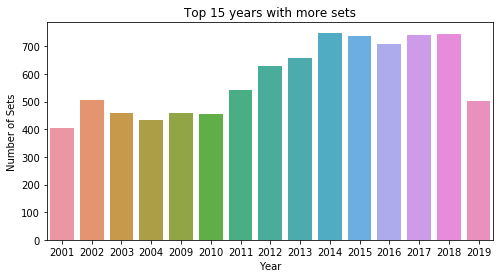

In [8]:
plt.figure(figsize=(8,4))

top_15_years = year_counts[:15,]

sns.barplot(top_15_years.index, top_15_years.values)

plt.title('Top 15 years with more sets')
plt.xlabel('Year')
plt.ylabel('Number of Sets')
plt.show()

Highest quantity of sets is dominated by the 21st century. 

There is a gap between 2004 and 2009, which can also be seen in the next plot.

### Overall Years

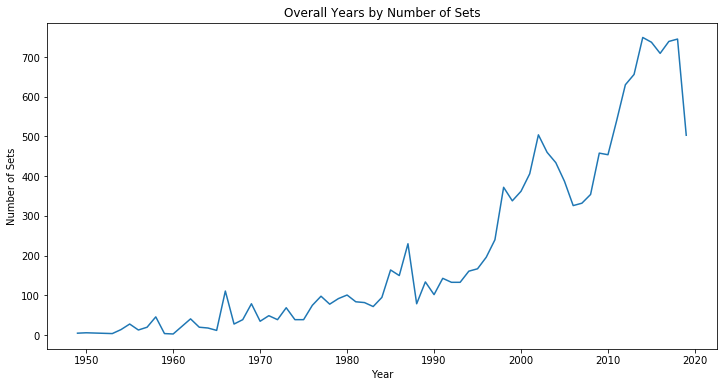

In [9]:
plt.figure(figsize=(12,6))

sns.lineplot(year_counts.index, year_counts.values)

plt.title('Overall Years by Number of Sets')
plt.xlabel('Year')
plt.ylabel('Number of Sets')
plt.show()

Increasing trend from the late 90s. 

As stated before, the dip between 2004 and 2009 is evident.

The drop at the end is 2019, which is still midway.

## Plotting Themes

Analysing the differences between Parent themes and Root themes (which I engineer from available data 
                                                                 after having carefully examined the dataframes)

### Parent Themes

Parent theme: Theme that has other themes directly associated to it. May have a parent theme of its own.

    Example: id name    parent_id
             1  Technic 
                    ...
             5  Model       1
             6  Airport     5

    Technic is a parent (root) of Model, which is a parent (non-root) of Airport.

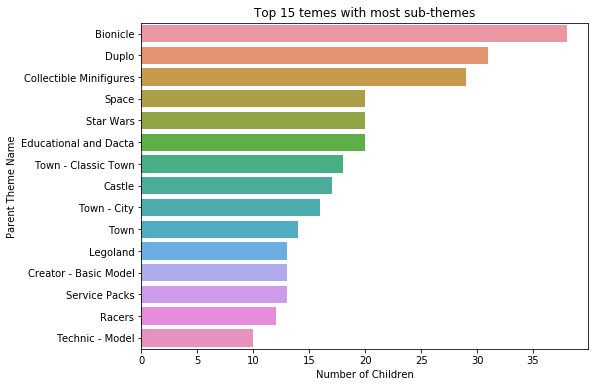

In [10]:
plt.figure(figsize=(8,6))

# Get top 15 parents
top_15_parents = themes_raw["parent_id"].value_counts()[:15,]

# Associate parent_id with the name of the parent theme
top_15_names = [themes_raw[themes_raw["id"] == idx]["name"].values[0] for idx in top_15_parents.index]

sns.barplot(top_15_parents.values, top_15_names, orient="h")

plt.title('Top 15 temes with most sub-themes')
plt.xlabel('Number of Children')
plt.ylabel('Parent Theme Name')
plt.show()

### Root Themes

Root theme: Theme that has no parent_id

In [11]:
# Fill root theme's parent_id as 0
themes_raw["parent_id"] = themes_raw["parent_id"].fillna(0).astype(int)

parent_dict = themes_raw.set_index('id').to_dict()['parent_id']

# Returns root theme
def get_root(x):
    return x if parent_dict[x] == 0 else get_root(parent_dict[x])

# Merge root theme column
themes = themes_raw.merge(pd.DataFrame(pd.Series({x: get_root(x) for x in parent_dict.keys()}), columns=('root_id', )),
                left_on='id',
                right_index=True)

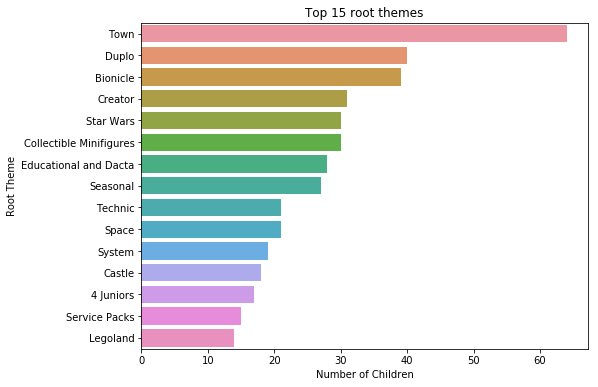

In [12]:
plt.figure(figsize=(8,6))

# Top 15 root themes
top_15_roots = themes["root_id"].value_counts()[:15,]

# Associate root_id with the name of the root theme
top_15_names = [themes[themes["id"] == idx]["name"].values[0] for idx in top_15_roots.index]
sns.barplot(top_15_roots.values, top_15_names, orient="h")

plt.title('Top 15 root themes')
plt.xlabel('Number of Children')
plt.ylabel('Root Theme')
plt.show()

### Set Themes

In [13]:
set_theme_counts = sets_raw["theme_id"].value_counts()
sets_raw["theme_id"].describe()

count    14787.000000
mean       366.773450
std        193.061026
min          1.000000
25%        204.000000
50%        412.000000
75%        505.000000
max        680.000000
Name: theme_id, dtype: float64

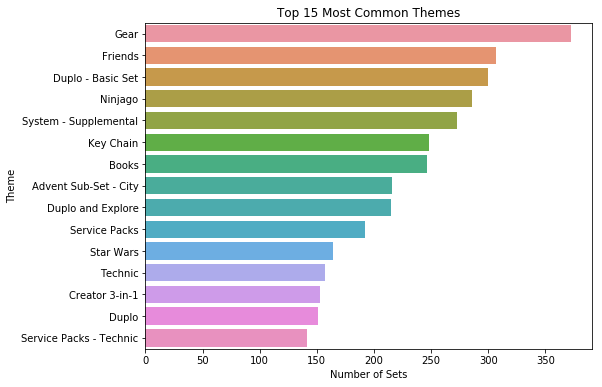

In [14]:
plt.figure(figsize=(8,6))

# Top 15 themes
top_15_themes = set_theme_counts[:15,]

# Associate root_id with the name of the root theme
theme_names = [themes_raw[themes_raw["id"] == idx]["name"].values[0] for idx in top_15_themes.index]
sns.barplot(top_15_themes.values, theme_names, orient="h")

plt.title('Top 15 Most Common Themes')
plt.xlabel('Number of Sets')
plt.ylabel('Theme')
plt.show()

### Distribution of Most Common Themes by Year

In [15]:
names = dict(zip(top_15_themes.index, theme_names))

def match_name(theme_id):
    return names[theme_id]

sets_by_year = sets_raw.groupby(["theme_id", "year"], as_index=False)["set_num"].count()
top15_sets_by_year = sets_by_year[sets_by_year["theme_id"].isin(top_15_themes.index)]

# Add theme name for better plot readability
top15_sets_by_year = top15_sets_by_year.merge(
    pd.DataFrame(
        pd.Series({x: match_name(x) for x in top15_sets_by_year["theme_id"]}),
        columns=('theme_name', )
    ),
    left_on='theme_id',
    right_index=True)

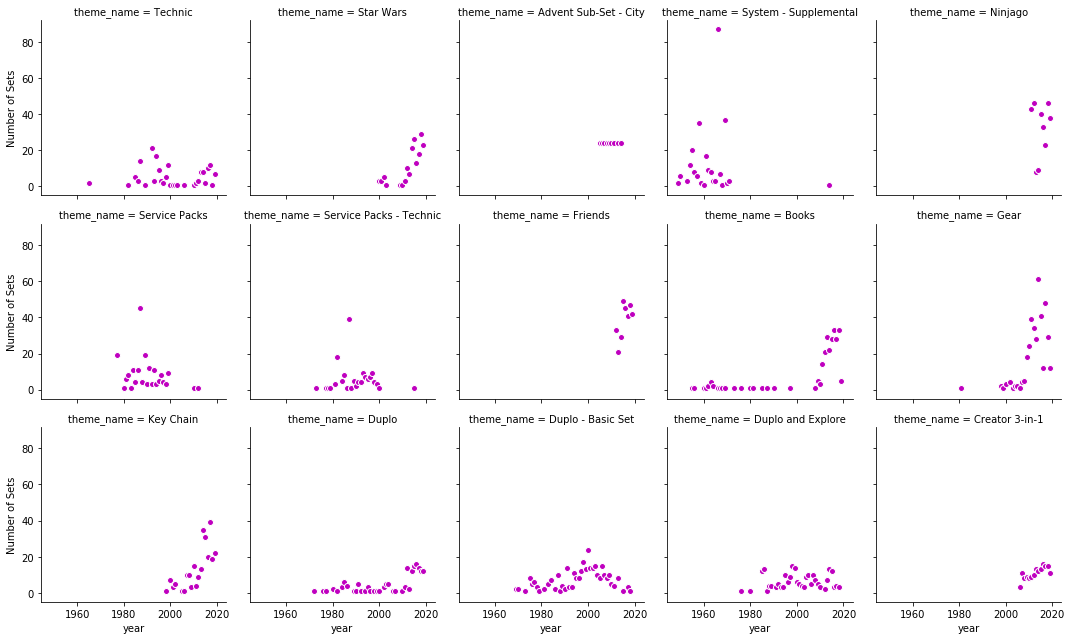

In [16]:
g = sns.FacetGrid(top15_sets_by_year, col="theme_name", col_wrap=5, height=3)
g = g.map(plt.scatter, "year", "set_num", color="m", edgecolor="w")
g.set_ylabels("Number of Sets")
plt.show()

Here, certain trends can be seen. Examples include the increase popularity in Star Wars and Books, the drop of Service Packs (common in the eighties and nineties, but not so much now) and the consistency of Duplo theme throughout the years.

### Quantity of Parts by Year

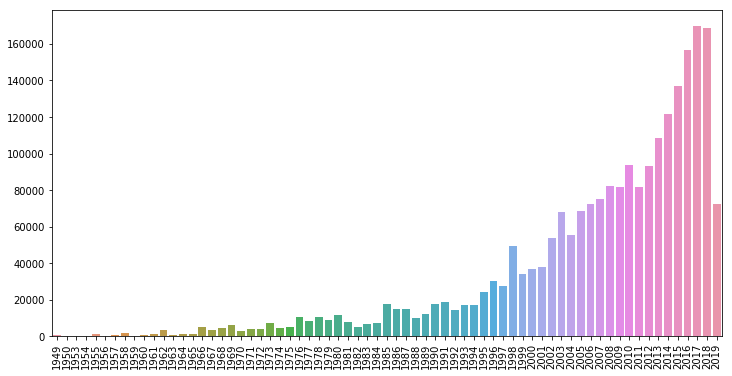

In [17]:
qnt_parts = {}

for year in sets_raw.year.unique():
    year_df = sets_raw[sets_raw["year"] == year]
    qnt_parts[year] = year_df["num_parts"].sum()

x = list(qnt_parts.keys())
y = list(qnt_parts.values())

plt.figure(figsize=(12,6))
sns.barplot(x, y)
plt.xticks(rotation=90)
plt.show()

This trend is somewhat expected since there is an increase of sets that can be seen in earlier plots. Interestingly enough, we do not see the dip between 2004 and 2009 in parts like we saw in the quantity of sets.

# Predicting 2018

## Dropping Features

In [18]:
themes_merge = themes.drop("name", axis=1)
sets_merge = sets_raw.drop(["name", "set_num"], axis=1)

## Merge Dataframes

Merging parent_id and root_id features into information about sets.

In [19]:
# Merge on themes_id == id 
merged = sets_merge.merge(themes_merge, left_on="theme_id", right_on="id").drop("id", axis=1)
merged.head()

,year,theme_id,num_parts,parent_id,root_id
0,1965,1,43,0,1
1,1965,1,3,0,1
2,1985,1,191,0,1
3,1985,1,120,0,1
4,1986,1,39,0,1


## One Hot Encoding

In [20]:
# One Hot Encoding features since we can look at them as categorical/nominal with no ordinal value
merged_encoded = pd.get_dummies(merged, columns=["theme_id", "parent_id", "root_id"], prefix=["id", "parent", "root"])

merged_encoded["set_qnt"] = 1

# Group by year and sum all other features
merged_collapsed = merged_encoded.groupby(["year"]).sum()

# Drop 2019 since we are only halfway and we are predicting number of parts for 2018 (past) 
merged_collapsed.drop(merged_collapsed.index[-1], inplace=True)

merged_collapsed.reset_index(inplace=True)
merged_collapsed.tail()

,year,num_parts,id_1,id_2,id_3,id_4,id_5,id_6,id_7,id_8,...,root_621,root_625,root_646,root_654,root_668,root_669,root_671,root_676,root_680,set_qnt
63,2014,121733,8.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,749
64,2015,137156,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737
65,2016,156647,10.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,709
66,2017,169933,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,739
67,2018,168397,1.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,...,12.0,25.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,745


## Splitting data into Train and Test sets

In [21]:
test_year = merged_collapsed[merged_collapsed["year"] == 2018]
test_y = test_year["num_parts"]
test_X = test_year.drop("num_parts", axis=1)

# Drop 2018 from train set
train_data = merged_collapsed.drop(merged_collapsed.index[-1])

train_y = train_data["num_parts"]
train_X = train_data.drop("num_parts", axis=1)

## Auxiliary Methods

In [22]:
# Fit to model and predict
def fit_predict(model):
    return round(model.fit(train_X, train_y).predict(test_X)[0])

In [23]:
# Use adaptive boosting on model, fit training data and predict
def adaboost(model):
    return round(AdaBoostRegressor(model, n_estimators=100).fit(train_X, train_y).predict(test_X)[0])

In [24]:
# Output predictions and difference to real values
def output(pred):
    y = test_y.values[0]
    print("2018 num_parts: {}\nPrediction for 2018 num_parts: {}\nDistance to real value: {}".format(y, pred, abs(y - pred)))                                                                                           

## Base Models

I will be comparing 3 different regression models: 

    1. Linear Regression (which is essentially Ridge Regression with alpha=0)
    
    2. Ridge Regression 
    
    3. K-Nearest Neighbors Regression (5 neighbors)

Linear Regression can is ordinary least squares linear regression while
Ridge Regression is a least squares linear regression but with L2 regularization.
    
Linear Regression and K-Nearest Neighbors have similar results, while Ridge Regression presents the closest prediction.

KNN has slightly better results when using 2 or 3 neighbors, however I chose 5 to avoid potential overfitting while 
preserving good results.

### Linear Regression

In [25]:
linear_reg = fit_predict(LinearRegression())
output(linear_reg)

2018 num_parts: 168397
Prediction for 2018 num_parts: 135982.0
Distance to real value: 32415.0


### Ridge Regression

In [26]:
ridge = fit_predict(Ridge())
output(ridge)

2018 num_parts: 168397
Prediction for 2018 num_parts: 148422.0
Distance to real value: 19975.0


### K-Nearest Neighbors

In [27]:
knn = fit_predict(KNeighborsRegressor(n_neighbors=5))
output(knn)

2018 num_parts: 168397
Prediction for 2018 num_parts: 135746.0
Distance to real value: 32651.0


## Adaptive Boosting

Adaptive boosting is an ensemble method that has been showned to be able to improve performance of "weak" learners.

It uses multiple estimators in a 'Out of many, one', meaning that even though the individual learners are weak, the combined
result is strong.

It is somewhat less susceptible to overfitting, which is nice.


While all three regression models improve with technique, K-Nearest Neighbors has by far the best result.

### Linear Regression

In [28]:
lr_boost = adaboost(LinearRegression())
output(lr_boost)

2018 num_parts: 168397
Prediction for 2018 num_parts: 151744.0
Distance to real value: 16653.0


### Ridge Regression

In [29]:
rd_boost = adaboost(Ridge())
output(rd_boost)

2018 num_parts: 168397
Prediction for 2018 num_parts: 151592.0
Distance to real value: 16805.0


### K-Nearest Neighbors

In [30]:
knn_boost = adaboost(KNeighborsRegressor(n_neighbors=5))
output(knn_boost)

2018 num_parts: 168397
Prediction for 2018 num_parts: 167276.0
Distance to real value: 1121.0
